## Naive Bayes
In class we have learned Bernoulli naive Bayes model. In this section, we will apply Bernoulli naive Bayes model on a classification task. We are going to use `numpy` and `matplotlib` in Python, the first thing we need to do is to import the packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# we recommand you to fix the random seed at the start for debugging
np.random.seed(2021)

Our experiment consists of three steps:
1. Load dataset
2. Implement Bernoulli naive Bayes model
3. Test the result

You need to write some codes and answer some analytical questions during our experiment.

### Load dataset
[UCL Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) is a famous binary classification dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). It is used to predict whether income exceed \$50K/year based on censurs data. The original dataset includes 48,842 samples. Each sample has 6 continuous features such as age, and 8 categorical features such as education. [LIBSVM dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) further transfers the continuous features and categorical features into 123 binary features. Our dataset, which is stored as `a1a.txt`, is drawn from LIBSVM dataset and contains 1,605 samples with 123 features in total. We use the first 1,000 samples as training set and others as test set. The following function will automatically parse the text file, divide samples as training set and test set and finally return them as `np.array` objects. 

In [2]:
def load_data(data_path="a1a.txt"):
    labels = []
    x = None
    with open(data_path, "r") as f:
        for i,line in enumerate(f.readlines()):
            if i % 200 == 0:
                print("Processing line No.{}.".format(i))
            data_list = line.split()
            label = (int(data_list[0]) + 1) / 2
            feature_idx = [int(l.split(":")[0]) for l in data_list[1:]]
            labels.append(label)
            features = np.zeros(123)
            features[feature_idx] = 1.0

            if x is None:
                x = features
            else:
                x = np.c_[x,features]

    x = x.T
    labels = np.array(labels).astype(int)
    all_idx = np.arange(x.shape[0])
    np.random.shuffle(all_idx)
    X_train = x[all_idx[:1000]]
    y_train = labels[all_idx[:1000]]
    X_test  = x[all_idx[1000:]]
    y_test  = labels[all_idx[1000:]]
    return X_train, y_train, X_test, y_test
# load the dataset
# X_train: feature matrix of train set
# y_train: labels of train set 
# X_test: feature matrix of test set
# y_test: labels of test set 
X_train, y_train, X_test, y_test = load_data()
print("features of the first 10 samples:")
print(X_train[:10])
print("labels of the first 10 samples:")
print(y_train[:10])

Processing line No.0.
Processing line No.200.
Processing line No.400.
Processing line No.600.
Processing line No.800.
Processing line No.1000.
Processing line No.1200.
Processing line No.1400.
Processing line No.1600.
features of the first 10 samples:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
labels of the first 10 samples:
[0 1 0 0 0 0 1 1 0 1]


### Implement Bernoulli naive Bayes model
Given sample $(\boldsymbol x, y)$, where $\boldsymbol x$ is the feature vector and $y$ is the label, naive Bayes assume $\boldsymbol x_j$'s are conditionally independent given $y$:
$$
p(\boldsymbol x, y)=p(y) p(\boldsymbol x \mid y)=p(y) \prod_{j=1}^{n} p\left(\boldsymbol x_{j} \mid y\right).
$$
Because our task is a binary classification problem, we assume the label is randomly generated according to a Bernoulli distribution with $p(Y=1) = \phi_{Y}$, i.e. $p(y) =\phi_{Y}^{y}(1- \phi_{{Y}})^{1-y}$. 

Bernoulli naive Bayes assume the features of data follow **multivariate Bernoulli distribution**, which means there may be multiple features but each feature follows a Bernoulli distribution given $y$ with $p\left(\boldsymbol x_{j}=1 \mid y=b\right)=\phi_{j \mid y=b}$, i.e. $p\left(\boldsymbol x_{j} \mid y=b\right)=\phi_{j \mid y=b}^{\boldsymbol x_{j}}\left(1-\phi_{j \mid y=b}\right)^{1-\boldsymbol x_{j}}$.

Now we can write the likelihood of training data $\left(\boldsymbol x^{(1)}, y^{(1)}\right), \ldots,\left(\boldsymbol x^{(m)}, y^{(m)}\right)$ as :
$$
L\left(\phi_{Y}, \phi_{j \mid y=0}, \phi_{j \mid y=1}\right)=\prod_{i=1}^{m} p\left(\boldsymbol x^{(i)}, y^{(i)}\right),
$$
where $\phi_{Y}, \phi_{j \mid y=0}, \phi_{j \mid y=1}$ are the model parameters to be estimated. The log-likelihood of above equation can be transformed as:
$$
\begin{aligned}
\log L\left(\phi_{ Y}, \phi_{j \mid y=0}, \phi_{j \mid y=1}\right) &=\sum_{i=1}^{m} \log p\left(\boldsymbol x^{(i)}, y^{(i)}\right) \\
&=\sum_{i=1}^{m} \log \left(p\left(y^{(i)}\right) \prod_{j=1}^{d} p\left(\boldsymbol x_{j}^{(i)} \mid y^{(i)}\right)\right) \\
&=\underbrace{\sum_{i=1}^{m} \log p\left(y^{(i)}\right)}_{(\mathbf{I})}+\underbrace{\sum_{i=1}^{m} \sum_{j=1}^{d} \log p\left(\boldsymbol x_{j}^{(i)} \mid y^{(i)}\right)}_{(\mathrm{II})}.
\end{aligned}
$$
Therefore, maximizing the log-likelihood function is equivalent to maximize $(\mathrm{I})$ and $(\mathrm{II})$. 

#### Q1.From $(\mathrm{I})$, we can derive that the best estimator: $\phi_Y = \frac{\text{count}_y(1)}{m}$, where $\text{count}_y(b)$ is the number of samples with label $y=b$:
$$
\text{count}_y(b)=\sum_{i=1}^{m} \mathbf{1}\left\{y^{(i)}=b\right\},
$$
#### and we have $\text{count}_y(0) + \text{count}_y(1) = m$.  Please write the full derivation of $\phi_Y$.

**Your answer:** *You can choose to write your answer here, or submit another seperate pdf file or image. We recommend you to use LaTeX, but you can also choose to write the answer by hand and take a picture.*

#### Q2. Complete following code to estimate $\phi_Y$ from data.

In [3]:
def estimatePhiY(y):
    phi_y = np.random.rand()
    
    ## start of your code
    phi_y = np.sum(y) / y.shape[0]    
    
    ## end of your code
    
    return phi_y
phi_y = estimatePhiY(y_train)
print(phi_y)

0.24


#### Q3. Similar to Question #1, from $(\mathrm{II})$, the maximum likelihood estimate of $\phi_{j \mid y=b}$ can be shown as:
$$
\phi_{j \mid y=b}=\frac{\text{count}_{j,y}(1,b)}{\text{count}_y(b) } \text { for } b=1,0,
$$
#### where $\text{count}_{j,y}(a,b)$ is the number of samples with $j$-th feature $x_j = a$ and label $y=b$, i.e.
$$
\text{count}_{j,y}(a,b) = \sum_{i=1}^{m} \mathbf{1}\left\{x_{j}^{(i)}=a, y^{(i)}=b\right\}.
$$ 
#### and we have $\text{count}_{j,y}(1,b) + \text{count}_{j,y}(0,b) = \text{count}_y(b)$.  Please write the full derivation for $\phi_{j \mid y=b}$ .

**Your answer:** *You can choose to write your answer here, or submit another seperate pdf file or image. We recommend you to use LaTeX, but you can also choose to write the answer by hand and take a picture.*

In practice, we also add Laplace smoothing when estimating $\phi_{j \mid y=b}$, so the final estimator becomes:
$$
\phi_{j \mid y=b}=\frac{\text{count}_{j,y}(1,b) + 1}{\text{count}_y(b) + 2} \text { for } b=1,0.
$$
#### Q4. Now, complete following code to estimate $\phi_{j \mid y=b}$.

In [4]:
def estimatePhiX(X, y):
    phi_x_y1 = np.random.rand(X.shape[1])
    phi_x_y0 = np.random.rand(X.shape[1])
    
    ## start of your code
    ## don't forget Laplace smoothing
    phi_x_y1 = (np.sum(X.T * y, axis=1) + 1 ) / (np.sum(y) + 2)
    phi_x_y0 = (np.sum(X.T * (1 - y),axis=1) + 1) /(y.shape[0] - np.sum(y) + 2)    
    
    ## end of your code
    
    return  phi_x_y1, phi_x_y0
phi_x_y1, phi_x_y0 = estimatePhiX(X_train, y_train)

Once we have the parameters, we can make predictions. Given a new sample with feature vector $\boldsymbol x$, the posterior probability is computed through:
$$
\begin{aligned}
p(y=1 \mid \boldsymbol x) &=\frac{p(x \mid y=1) p(y=1)}{p(\boldsymbol x)} \\
&=\frac{p(\boldsymbol x \mid y=1) p(y=1)}{p(\boldsymbol x \mid y=1) p(y=1)+p(\boldsymbol x \mid y=0) p(y=0)} \\
&=\frac{\prod_{j=1}^{n} p\left(\boldsymbol x_{j} \mid y=1\right) p(y=1)}{\prod_{j=1}^{n} p\left(x_{j} \mid y=1\right) p(y=1)+\prod_{j=1}^{n} p\left(\boldsymbol x_{j} \mid y=0\right) p(y=0)}\\
&= \frac{\prod_{j=1}^{n} \phi_{j\mid y=1}^{\boldsymbol x_j}\left(1-\phi_{j\mid y=1}\right)^{1 - \boldsymbol x_j} \phi_{Y}}{ \prod_{j=1}^{n}\phi_{j\mid y=1}^{\boldsymbol x_j}\left(1 - \phi_{j\mid y=1}\right)^{1 - \boldsymbol x_j} \phi_{Y}+\prod_{j=1}^{n}\phi_{j\mid y=0}^{\boldsymbol x_j} \left(1 - \phi_{j\mid y = 0}\right)^{1 - \boldsymbol x_j} (1 -\phi_{Y})}
\end{aligned}
$$

The labels can be determined based on the probability with a threhold $t$:
$$
{y} = \left\{
\begin{matrix}
1 & {\text{if } {p(y= 1\mid\boldsymbol x ) } > t}\\
0 & \text{otherwise}.
\end{matrix}\right.
$$
We can simply set $t = 0.5$.

#### Q5. Now, please the complete following code to compute posterior probability $p(y=1|\mathbf{x})$ and get the labels. 

In [5]:
def predict(phi_x_y1, phi_x_y0, phi_y, X, t = 0.5):
    prob = np.random.rand(X.shape[0])
    predicted_y = np.ones(X.shape[0], dtype=int)
    
    ## start of your code    
    py1 = np.prod(X * phi_x_y1 + (1 - X) * (1 - phi_x_y1), axis = 1) * phi_y
    py0 = np.prod(X * phi_x_y0 + (1 - X) * (1 - phi_x_y0), axis = 1) * (1 - phi_y)
    
    prob = py1 / (py1 + py0)    
    predicted_y = (prob >= t).astype(int)    
    
    ## end of your code
    
    return prob, predicted_y

### Test the result

With the optimal parameters, we can do the prediction. Firstly, let us see how our model works on the train set. Apply `predict` function on train set to get the probability and labels. 

In [6]:
# set the threshold
threshold = 0.5
prob_train, predicted_y_train = predict(phi_x_y1, phi_x_y0, phi_y, X_train, threshold)

The input of following function are label vector and probability, and an optional threshold. It will plot the probability. Samples with different labels will be denoted using different markers for better illustration.

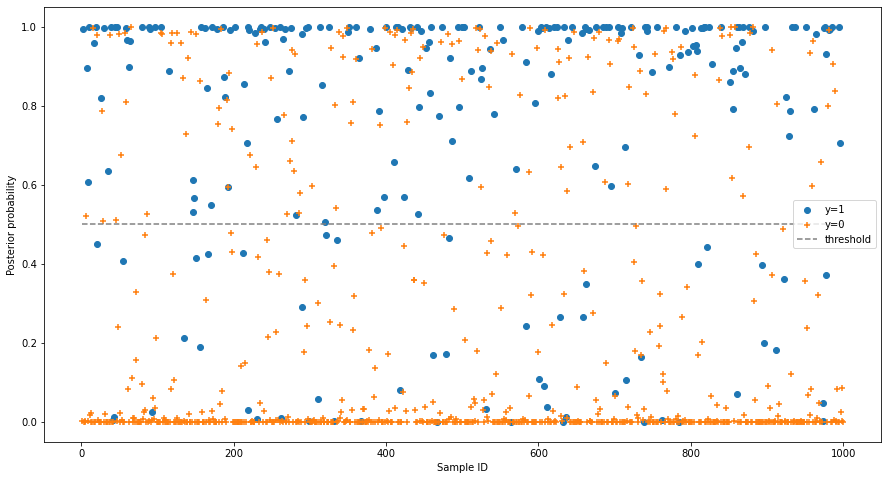

In [7]:
def plot_probability(y, prob, t=0.5):
    plt.figure(figsize=(15, 8))
    x = np.arange(1, y.shape[0]+1)
    x1 = np.extract(y == 1, x)
    x0 = np.extract(y == 0, x)
    prob1 = np.extract(y == 1, prob)
    prob0 = np.extract(y == 0, prob)
    plt.scatter(x1, prob1, label="y=1")
    plt.scatter(x0, prob0, label="y=0", marker="+")
    plt.xlabel("Sample ID")
    plt.ylabel("Posterior probability")
    plt.hlines(y=t, xmin=x[0], xmax=x[-1], color="gray", label="threshold", linestyles = "dashed")
    plt.legend()
plot_probability(y_train, prob_train, threshold)

Here we also define a function to compute the accuracy. 

In [8]:
def accuracy(pred_y, y):
    return np.sum((pred_y == y).astype(float) ) / y.shape[0] 
print(accuracy(predicted_y_train, y_train))

0.799


We can also adjust threshold $t$ according to the probability figure and result to achieve higher accuracy. 

If you have already gotten some good results on train set, we can do the prediction on test set. **Note that if your implementation is correct and threshold is set to $0.5$, your accuracy should be higher than $0.75$.**

0.8066115702479338


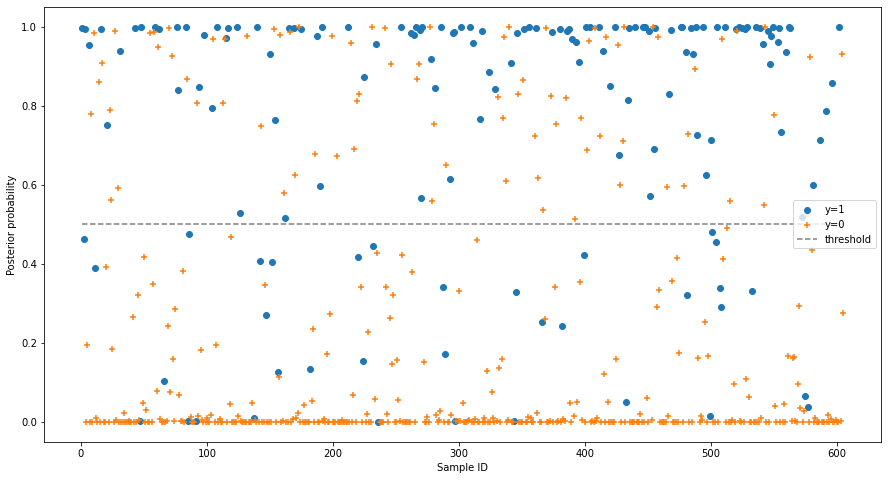

In [9]:
prob_test, predicted_y_test = predict(phi_x_y1, phi_x_y0, phi_y, X_test, threshold)
plot_probability(y_test, prob_test, threshold)
print(accuracy(predicted_y_test, y_test))

### Analytical problem
#### Q6. Try to remove Laplace smoothing and further test the results. Explain the role of Laplace smoothing based on your experiments.

**You answer:**